# Orbit numerical integrator

Use a numerical orbit integrator whose initial state is given by:
    
$$X = (-3850, 3072, 4925) \; km$$ e $$\dot{X} = (-4.838, -5.839, -0.047) \; km/s $$

in two situations:
    
a) Pure keplerian motion;

b) Geopotential considering only the zonal coefficients up to order 6.

Present your results in a graphical fashion: $M(t)$, $\omega(t)$ and $\Omega(t)$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Keplerian

### Integration

In [2]:
# Initial conditions
x_vec = np.array( (-3850,3072,4925) )
v_vec = np.array( (-4.838,-5.839,-0.047) )
mu = 0.39860e6

In [3]:
# Integrator
def RK4(f, x0, tf, dt, t0=0):
    # Time vector
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(nt-1):
        # At the kth time step, each parameter k_n is computed
        k1 = dt*f(t[k], x[:, k])
        k2 = dt*f(t[k] + dt/2, x[:, k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:, k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x, t

In [4]:
# Derivatives
def X_ddot(t, X):
    '''
    Returns the derivative of the state vector X
    ----------
    Arguments:
        t {float} -- time, in seconds
        X {np.array} -- state vector=(x, y, z, vx, vy, vz)
    ----------
    Returns:
        (6,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot)
    '''
    
    x_dot = X[3:]
    v_dot = -mu*X[:3]/np.linalg.norm(X[:3])**3 # simply the acceleration
    X_dot_dot = np.concatenate((x_dot, v_dot), axis=None)    
    return X_dot_dot

In [5]:
# Integrating
f = lambda t, X: X_ddot(t, X)

x0 = np.concatenate((x_vec, v_vec))
t0 = 0
tf = 6000
dt = tf/400

x, t = RK4(f, x0, tf, dt, t0)

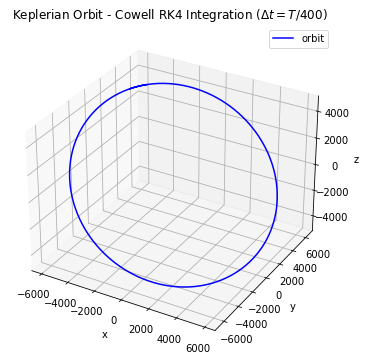

In [6]:
# Plotting
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x[0][:], x[1][:], x[2][:], 'blue', label="orbit")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Cowell RK4 Integration ($\Delta t=T/400$)")


plt.show()

### Orbital elements

In [7]:
# Initializing elements
K = np.array([0, 0, 1])
h = []
n = []
e = []
Omega = []
omega = []
M = []

# Calculating each at time t
for i in range(x.shape[1]):
    v = np.linalg.norm(x[3:,i])
    r = np.linalg.norm(x[:3,i])
    
    # h at time i
    h_i = np.cross(x[:3,i], x[3:,i])
    h.append(h_i)
    
    # n at time i
    n_i = np.cross(h[i], K)
    n.append(n_i)
    
    # e at time i
    e_i = 1/mu*((v**2 - mu/r)*x[:3,i] - x[:3,i]@x[3:,i]*x[3:,i])
    e.append(e_i)
    
    # Omega at time i 
    Omega_i = np.arccos(n_i[0]/np.linalg.norm(n_i))
    while Omega_i > np.pi:
        Omega_i -= np.pi
    if n_i[1] > 0:
        Omega_i = - (Omega_i-np.pi)
    Omega.append(Omega_i)
    
    # omega at time i
    omega_i = np.arccos(n_i@e_i/np.linalg.norm(n_i)/np.linalg.norm(e_i))
    while omega_i > np.pi:
        omega_i -= np.pi
    if e_i[-1] > 0:
        omega_i = - (omega_i-np.pi)
    omega.append(omega_i)
    
    # Mean anomaly at time i
    p_i = np.linalg.norm(h_i)**2/mu
    a_i = p_i/(1-np.linalg.norm(e_i)**2)
    T = np.sqrt(4*np.pi**2/mu*a_i**3)
    M_i = np.sqrt(mu/a_i**3)*(t[i] - T)
    while M_i > np.pi:
        M_i -= np.pi
    while M_i < 0:
        M_i += np.pi
    M.append(M_i)
    
h = np.array(h)
n = np.array(n)
e = np.array(e)
Omega = np.array(Omega)
omega = np.array(omega)
M = np.array(M)

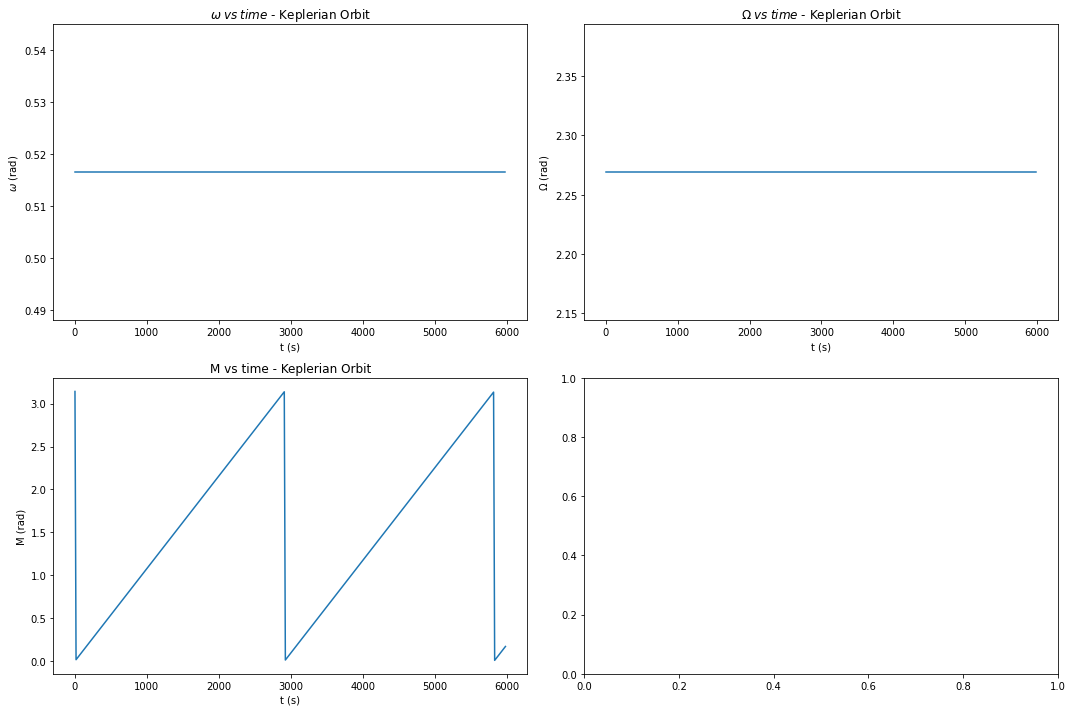

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax[0, 0].plot(t, np.round(omega, 4), label='Argument of perigee')
ax[0, 0].set_title(r"$\omega \; vs \; time$ - Keplerian Orbit")
ax[0, 0].set_ylabel(r"$\omega$ (rad)")
ax[0, 0].set_xlabel("t (s)")

ax[0, 1].plot(t, Omega, label='Longitude of the ascending node')
ax[0, 1].set_title(r"$\Omega \; vs \; time$ - Keplerian Orbit")
ax[0, 1].set_ylabel(r"$\Omega$ (rad)")
ax[0, 1].set_xlabel("t (s)")

ax[1, 0].plot(t, M, label='Mean anomaly')
ax[1, 0].set_title(r"M vs time - Keplerian Orbit")
ax[1, 0].set_ylabel(r"M (rad)")
ax[1, 0].set_xlabel("t (s)")

plt.tight_layout()
plt.show()

## Geopotential

### Integration


According to Bate, Muller and White:
    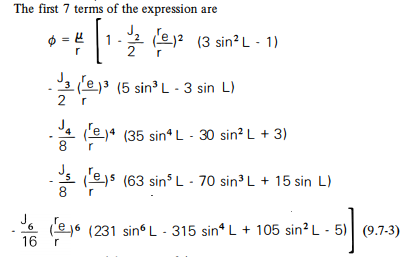

which gives us:
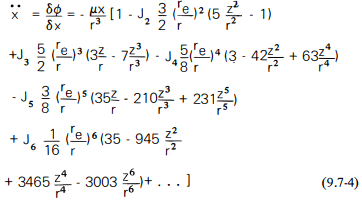

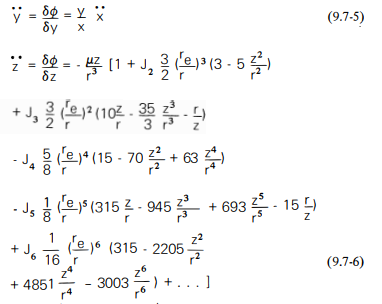

In [9]:
# Initializing coefficients
J2 = 1082.64e-6
J3 = -2.5e-6
J4 = -1.6e-6
J5 = -0.15e-6
J6 = 0.57e-6
J7 = -0.44e-6

r_e = 6378

In [10]:
# Derivatives as above
def geopotential6(t, X):
    '''
    Returns the derivative of the state vector X considering geopotential terms until order 6
    ----------
    Arguments:
        t {float} -- time, in seconds
        X {np.array} -- state vector=(x, y, z, vx, vy, vz)
    ----------
    Returns:
        (6,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot)
    '''
    x = X[0]
    y = X[1]
    z = X[2]
    r = np.linalg.norm(X[:3])
    
    x_ddot = - mu*x/r**3* (1 - J2*(3/2*(r_e/r)**2)*(5*(z/r)**2 - 1)
                            + J3*5/2*(r_e/r)**3*(3*(z/r) - 7*(z/r)**3)
                            - J4*5/8*(r_e/r)**4*(3 - 42*(z/r)**2 + 63*(z/r)**4)
                            + J5*3/8*(r_e/r)**5*(35*(z/r) - 210*(z/r)**3 + 231*(z/r)**5)
                            + J6*1/16*(r_e/r)**6*(35 - 945*(z/r)**2 + 3465*(z/r)**4 - 3003*(z/r)**6))
        
    y_ddot = y/x*x_ddot
    
    z_ddot = - mu*z/r**3* (1 + J2*(3/2*(r_e/r)**3)*(3 - 5*(z/r)**2)
                            + J3*3/2*(r_e/r)**2*(10*(z/r) - 35/3*(z/r)**3 - (r/z))
                            - J4*5/8*(r_e/r)**4*(15 - 70*(z/r)**2 + 63*(z/r)**4)
                            + J5*1/8*(r_e/r)**5*(315*(z/r) - 945*(z/r)**3 + 693*(z/r)**5 - 15*(r/z))
                            + J6*1/16*(r_e/r)**6*(315 - 2205*(z/r)**2 + 4851*(z/r)**4 - 3003*(z/r)**6))
    
    x_dot = X[3:]
    v_dot = np.array([x_ddot, y_ddot, z_ddot]) # the acceleration
    X_dot_dot = np.concatenate((x_dot, v_dot), axis=None) 
    
    return X_dot_dot

In [11]:
# Integrating
f = lambda t, X: geopotential6(t, X)

x0 = np.concatenate((x_vec, v_vec))
t0 = 0
tf = 6000
dt = tf/400

x2, t2 = RK4(f, x0, tf, dt, t0)

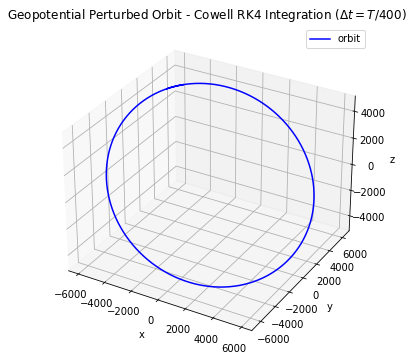

In [12]:
# Plotting
fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x2[0][:], x2[1][:], x2[2][:], 'blue', label="orbit")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Geopotential Perturbed Orbit - Cowell RK4 Integration ($\Delta t=T/400$)")


plt.show()

### Orbital elements

In [13]:
# Initializing elements
K = np.array([0, 0, 1])
h = []
n = []
e = []
Omega = []
omega = []
M = []

# Calculating each at time t
for i in range(x2.shape[1]):
    v = np.linalg.norm(x2[3:,i])
    r = np.linalg.norm(x2[:3,i])
    
    # h at time i
    h_i = np.cross(x2[:3,i], x2[3:,i])
    h.append(h_i)
    
    # n at time i
    n_i = np.cross(h[i], K)
    n.append(n_i)
    
    # e at time i
    e_i = 1/mu*((v**2 - mu/r)*x2[:3,i] - x2[:3,i]@x2[3:,i]*x2[3:,i])
    e.append(e_i)
    
    # Omega at time i 
    Omega_i = np.arccos(n_i[0]/np.linalg.norm(n_i))
    while Omega_i > np.pi:
        Omega_i -= np.pi
    if n_i[1] > 0:
        Omega_i = - (Omega_i-np.pi)
    Omega.append(Omega_i)
    
    # omega at time i
    omega_i = np.arccos(n_i@e_i/np.linalg.norm(n_i)/np.linalg.norm(e_i))
    while omega_i > np.pi:
        omega_i -= np.pi
    if e_i[-1] > 0:
        omega_i = - (omega_i-np.pi)
    omega.append(omega_i)
    
    # Mean anomaly at time i
    p_i = np.linalg.norm(h_i)**2/mu
    a_i = p_i/(1-np.linalg.norm(e_i)**2)
    T = np.sqrt(4*np.pi**2/mu*a_i**3)
    M_i = np.sqrt(mu/a_i**3)*(t[i] - T)
    while M_i > np.pi:
        M_i -= np.pi
    while M_i < 0:
        M_i += np.pi
    M.append(M_i)
    
h = np.array(h)
n = np.array(n)
e = np.array(e)
Omega = np.array(Omega)
omega = np.array(omega)
M = np.array(M)

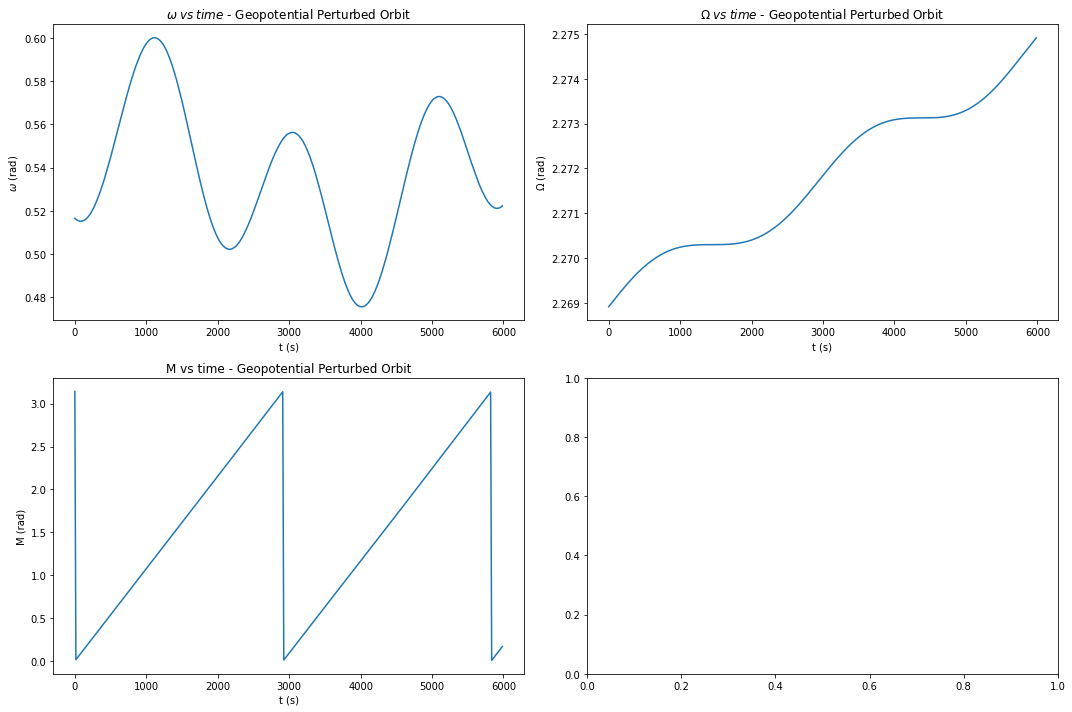

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax[0, 0].plot(t, np.round(omega, 4), label='Argument of perigee')
ax[0, 0].set_title(r"$\omega \; vs \; time$ - Geopotential Perturbed Orbit")
ax[0, 0].set_ylabel(r"$\omega$ (rad)")
ax[0, 0].set_xlabel("t (s)")

ax[0, 1].plot(t, Omega, label='Longitude of the ascending node')
ax[0, 1].set_title(r"$\Omega \; vs \; time$ - Geopotential Perturbed Orbit")
ax[0, 1].set_ylabel(r"$\Omega$ (rad)")
ax[0, 1].set_xlabel("t (s)")

ax[1, 0].plot(t, M, label='Mean anomaly')
ax[1, 0].set_title(r"M vs time - Geopotential Perturbed Orbit")
ax[1, 0].set_ylabel(r"M (rad)")
ax[1, 0].set_xlabel("t (s)")

plt.tight_layout()
plt.show()